# Carbon dioxoide injection in aquifer
This example demonstrates a custom K-value compositional model for the
injection of CO2 into a saline aquifer. The physical model for flow of CO2 is
a realization of the description in [11th SPE Comparative Solutions
Project](https://spe.org/en/csp/). Simulation of CO2 can be challenging, and
we load the HYPRE package to improve performance.

In [1]:
using Jutul, JutulDarcy
using HYPRE
using GLMakie
nx = 100
nz = 50
Darcy, bar, kg, meter, day = si_units(:darcy, :bar, :kilogram, :meter, :day)

(9.86923266716013e-13, 100000.0, 1.0, 1.0, 86400.0)

## Set up a 2D aquifer model
We set up a Cartesian mesh that is then transformed into an unstructured mesh.
We can then modify the coordinates to create a domain with a undulating top
surface. CO2 will flow along the top surface and the topography of the top
surface has a large impact on where the CO2 migrates.

In [2]:
cart_dims = (nx, 1, nz)
physical_dims = (1000.0, 1.0, 50.0)
mesh = UnstructuredMesh(CartesianMesh(cart_dims, physical_dims))

points = mesh.node_points
for (i, pt) in enumerate(points)
    x, y, z = pt
    x_u = 2*π*x/1000.0
    w = 0.2
    dz = 0.05*x + w*(30*sin(2.0*x_u) + 20*sin(5.0*x_u) + 10*sin(10.0*x_u) + 5*sin(25.0*x_u))
    points[i] = pt + [0, 0, dz]
end

## Set up simulation model
We set up a domain and a single injector. We pass the special :co2brine
argument in place of the system to the reservoir model setup routine. This
will automatically set up a compositional two-component CO2-H2O model with the
appropriate functions for density, viscosity and miscibility.

Note that this model can be run with a thermal mode by setting

In [3]:
domain = reservoir_domain(mesh, permeability = 1.0Darcy, porosity = 0.3, temperature = convert_to_si(30.0, :Celsius))
Injector = setup_well(domain, (65, 1, 1), name = :Injector)
model, parameters = setup_reservoir_model(domain, :co2brine, wells = Injector);

## Find the boundary and set increased volume
We find the left and right boundary of the model and increase the volume of
those cells. This mimicks a constant pressure boundary condition.

In [4]:
boundary = Int[]
for cell in 1:number_of_cells(mesh)
    I, J, K = cell_ijk(mesh, cell)
    if I == 1 || I == nx
        push!(boundary, cell)
    end
end
parameters[:Reservoir][:FluidVolume][boundary] *= 1000;

## Plot the model

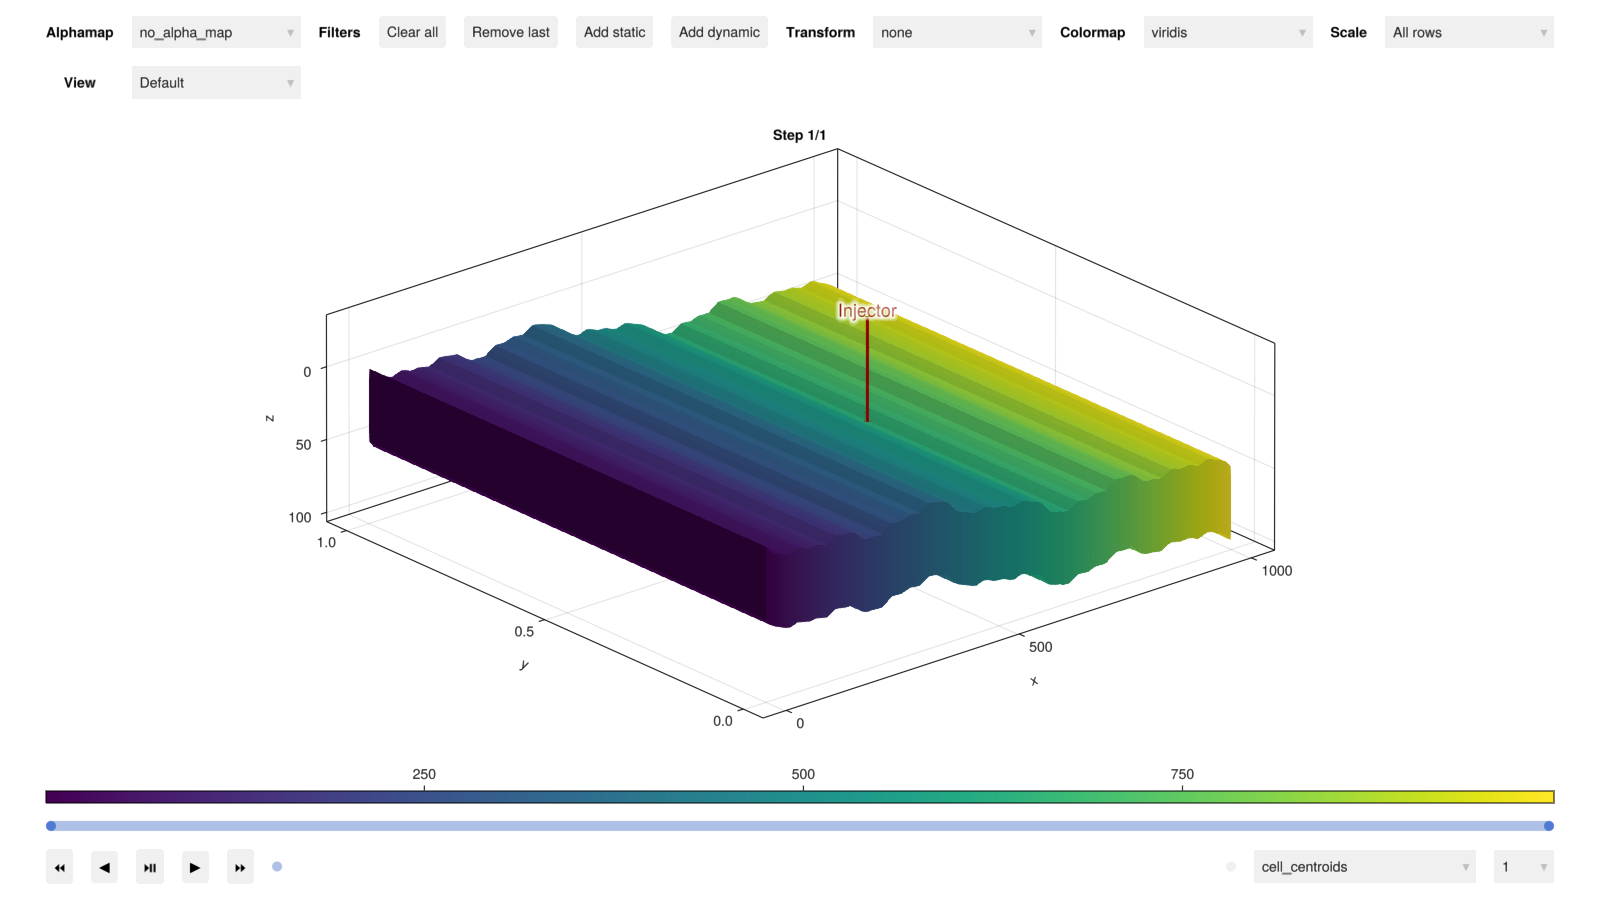

In [5]:
plot_reservoir(model)

## Set up schedule
We set up 25 years of injection and 25 years of migration where the well is
shut. The density of the injector is set to 900 kg/m^3, which is roughly
the density of CO2 at in-situ conditions.

In [6]:
nstep = 25
nstep_shut = 25
dt_inject = fill(365.0day, nstep)
pv = pore_volume(model, parameters)
inj_rate = 0.0075*sum(pv)/sum(dt_inject)

rate_target = TotalRateTarget(inj_rate)
I_ctrl = InjectorControl(rate_target, [0.0, 1.0],
    density = 900.0,
)

InjectorControl{TotalRateTarget{Float64}, Float64, Tuple{Tuple{Int64, Float64}}, Vector{Float64}, Missing}(TotalRateTarget with value 2.993721461187208e-6 [m^3/s], [0.0, 1.0], 900.0, ((1, 1.0),), 293.15, missing, 1.0)

Set up forces for use in injection

In [7]:
controls = Dict(:Injector => I_ctrl)
forces_inject = setup_reservoir_forces(model, control = controls)

Dict{Symbol, Any} with 3 entries:
  :Injector  => (mask = nothing,)
  :Reservoir => (sources = nothing, bc = nothing)
  :Facility  => (control = Dict{Symbol, InjectorControl{TotalRateTarget{Float64…

Forces with shut wells

In [8]:
forces_shut = setup_reservoir_forces(model)
dt_shut = fill(365.0day, nstep_shut);

Combine the report steps and forces into vectors of equal length

In [9]:
dt = vcat(dt_inject, dt_shut)
forces = vcat(fill(forces_inject, nstep), fill(forces_shut, nstep_shut));

## Set up initial state

In [10]:
state0 = setup_reservoir_state(model,
    Pressure = 200bar,
    OverallMoleFractions = [1.0, 0.0],
)

Dict{Any, Any} with 3 entries:
  :Injector  => Dict{Symbol, Any}(:OverallMoleFractions=>[1.0 1.0; 1.0e-10 1.0e…
  :Reservoir => Dict{Symbol, Any}(:PhaseMassMobilities=>[0.0 0.0 … 0.0 0.0; 0.0…
  :Facility  => Dict{Symbol, Any}(:TotalSurfaceMassRate=>[0.0], :WellGroupConfi…

## Simulate the schedule
We set a maximum internal time-step of 30 days to ensure smooth convergence
and reduce numerical diffusion.

In [11]:
wd, states, t = simulate_reservoir(state0, model, dt,
    parameters = parameters,
    forces = forces,
    max_timestep = 30day
)

Simulating 49 years, 50.45 weeks as 50 report steps   4%  ETA: 0:06:41
  Progress:  Solving step 2/50 (4.00% of time interval complete)


Simulating 49 years, 50.45 weeks as 50 report steps   6%  ETA: 0:07:53
  Progress:  Solving step 3/50 (6.00% of time interval complete)


Simulating 49 years, 50.45 weeks as 50 report steps   8%  ETA: 0:07:39
  Progress:  Solving step 4/50 (8.00% of time interval complete)


Simulating 49 years, 50.45 weeks as 50 report steps  10%  ETA: 0:07:13
  Progress:  Solving step 5/50 (10.00% of time interval complete)


Simulating 49 years, 50.45 weeks as 50 report steps  12%  ETA: 0:09:25
  Progress:  Solving step 6/50 (12.00% of time interval complete)


Simulating 49 years, 50.45 weeks as 50 report steps  14%  ETA: 0:13:40
  Progress:  Solving step 7/50 (14.00% of time interval complete)


Simulating 49 years, 50.45 weeks as 50 report steps  16%  ETA: 0:13:25
  Progress:  Solving step 8/50 (16.00% of time interval complete)


Simulating 49 years, 50.45 wee

ReservoirSimResult with 50 entries:

  wells (1 present):
    :Injector
    Results per well:
       :lrat => Vector{Float64} of size (50,)
       :orat => Vector{Float64} of size (50,)
       :control => Vector{Symbol} of size (50,)
       :bhp => Vector{Float64} of size (50,)
       :H₂O_mass_rate => Vector{Float64} of size (50,)
       :CO₂_mass_rate => Vector{Float64} of size (50,)
       :mass_rate => Vector{Float64} of size (50,)
       :rate => Vector{Float64} of size (50,)
       :grat => Vector{Float64} of size (50,)

  states (Vector with 50 entries, reservoir variables for each state)
    :LiquidMassFractions => Matrix{Float64} of size (2, 5000)
    :PhaseMassDensities => Matrix{Float64} of size (2, 5000)
    :OverallMoleFractions => Matrix{Float64} of size (2, 5000)
    :Saturations => Matrix{Float64} of size (2, 5000)
    :Pressure => Vector{Float64} of size (5000,)
    :VaporMassFractions => Matrix{Float64} of size (2, 5000)
    :TotalMasses => Matrix{Float64} of size (2,

## Plot the density of brine
The density of brine depends on the CO2 concentration and gives a good
visualization of where the mass of CO2 exists.

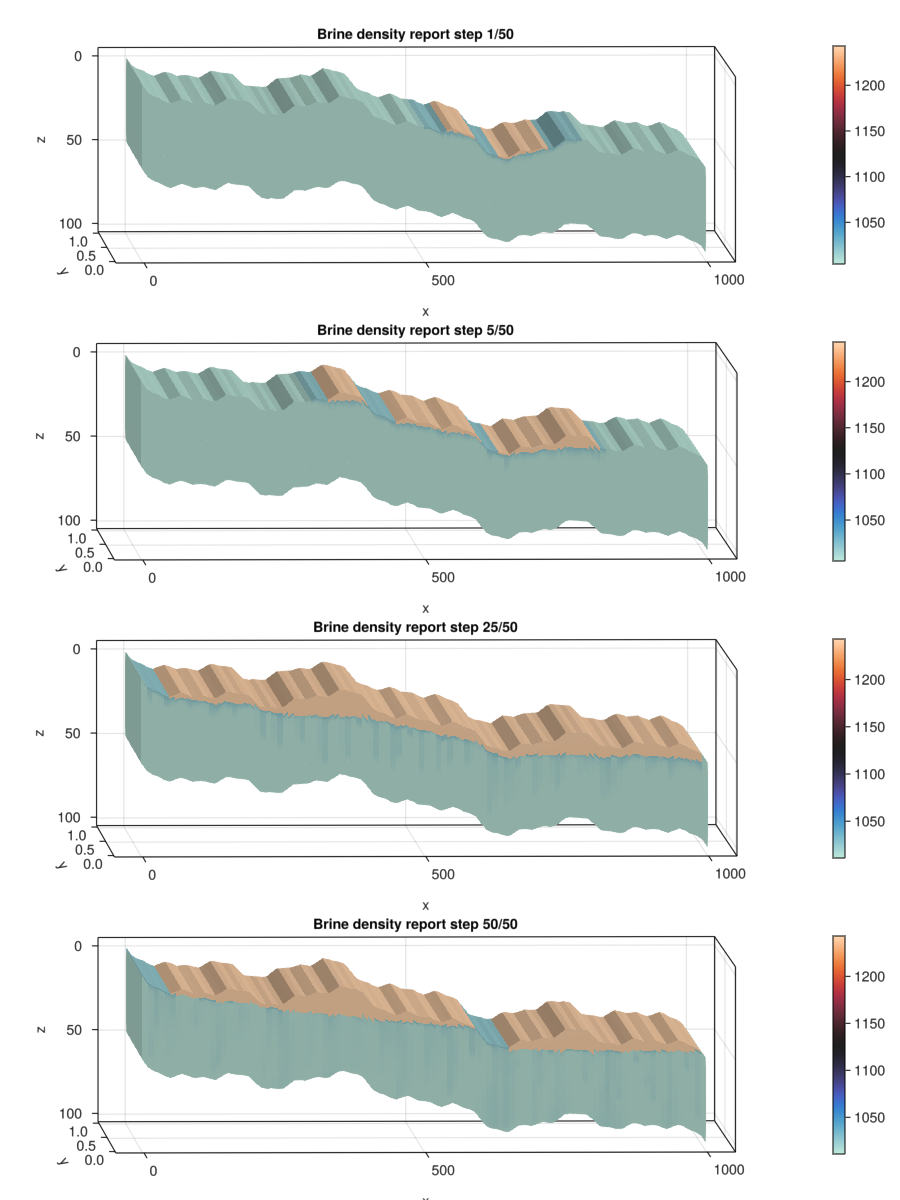

In [12]:
using GLMakie
function plot_co2!(fig, ix, x, title = "")
    ax = Axis3(fig[ix, 1],
        zreversed = true,
        azimuth = -0.51π,
        elevation = 0.05,
        aspect = (1.0, 1.0, 0.3),
        title = title)
    plt = plot_cell_data!(ax, mesh, x, colormap = :seaborn_icefire_gradient)
    Colorbar(fig[ix, 2], plt)
end
fig = Figure(size = (900, 1200))
for (i, step) in enumerate([1, 5, nstep, nstep+nstep_shut])
    plot_co2!(fig, i, states[step][:PhaseMassDensities][1, :], "Brine density report step $step/$(nstep+nstep_shut)")
end
fig

## Plot result in interactive viewer

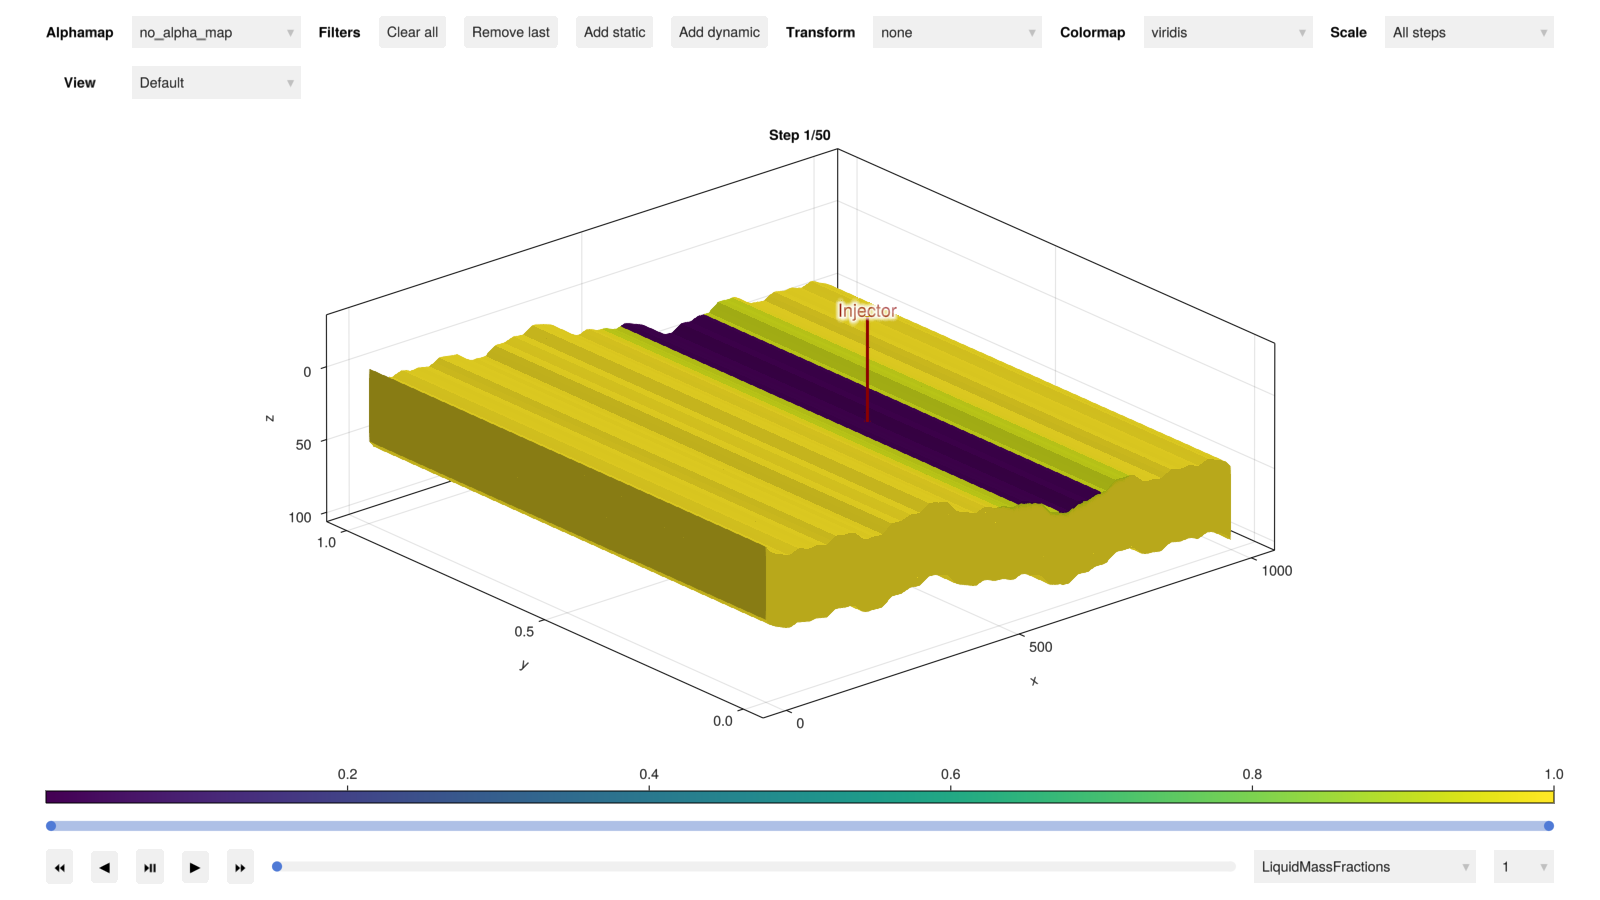

In [13]:
plot_reservoir(model, states)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*